In [6]:
# Import libs
import importlib_resources
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, hist, show, subplot, xlabel, ylim
from matplotlib.pyplot import boxplot, plot, show, title, xticks, yticks, ylabel, suptitle
from scipy.linalg import svd

In [7]:
# Load data from the file
filepath = "prostate/"
filename = "prostate.data.txt"
doc = pd.read_csv(filename, delimiter="\t")

# Drop number, svi, pgg45, train
doc = doc.drop(doc.columns[[0, 5, 8, 10]], axis=1)
# print(doc.head(), '\n')

# Extract attribute names 
attributeNames = doc.columns[[0, 1, 2, 3, 4, 6]].tolist()
print("Attribute Names:", attributeNames, '\n')

# Convert the DataFrame to a NumPy array
data = doc.to_numpy()
X = data[:, [0, 1, 2, 3, 4, 6]]  # Feature matrix
y = data[:, 5]   # Target vector

# Compute values of N, M.
N = len(X)
M = len(attributeNames)

Attribute Names: ['lcavol', 'lweight', 'age', 'lbph', 'lcp', 'lpsa'] 



[1.00000000e-03 1.25892541e-03 1.58489319e-03 1.99526231e-03
 2.51188643e-03 3.16227766e-03 3.98107171e-03 5.01187234e-03
 6.30957344e-03 7.94328235e-03 1.00000000e-02 1.25892541e-02
 1.58489319e-02 1.99526231e-02 2.51188643e-02 3.16227766e-02
 3.98107171e-02 5.01187234e-02 6.30957344e-02 7.94328235e-02
 1.00000000e-01 1.25892541e-01 1.58489319e-01 1.99526231e-01
 2.51188643e-01 3.16227766e-01 3.98107171e-01 5.01187234e-01
 6.30957344e-01 7.94328235e-01 1.00000000e+00 1.25892541e+00
 1.58489319e+00 1.99526231e+00 2.51188643e+00 3.16227766e+00
 3.98107171e+00 5.01187234e+00 6.30957344e+00 7.94328235e+00
 1.00000000e+01 1.25892541e+01 1.58489319e+01 1.99526231e+01
 2.51188643e+01 3.16227766e+01 3.98107171e+01 5.01187234e+01
 6.30957344e+01 7.94328235e+01 1.00000000e+02 1.25892541e+02
 1.58489319e+02 1.99526231e+02 2.51188643e+02 3.16227766e+02
 3.98107171e+02 5.01187234e+02 6.30957344e+02 7.94328235e+02]

Best lambda: 12.589254117941765


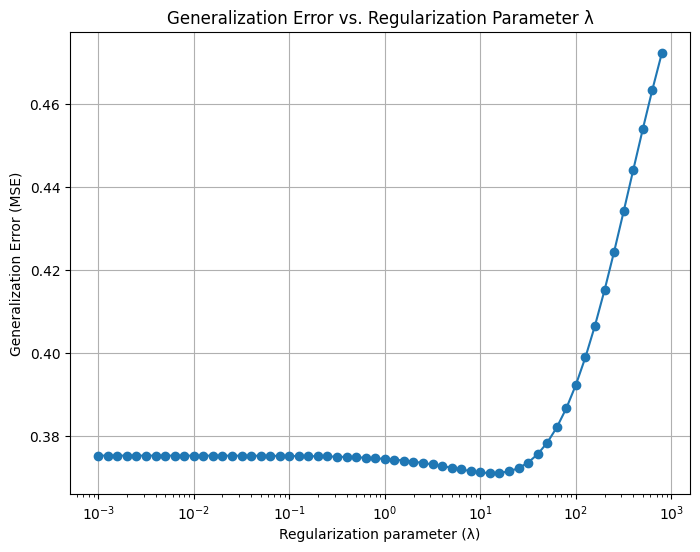

In [8]:
# Regression, part a: 1 & 2

from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

# lambdas = np.power(10.0, np.arange(0, 2, 0.1))
lambdas = np.power(10.0, np.arange(-3, 3, 0.1))

print(lambdas)

# Set up cross-validation
K = 10
cv = KFold(n_splits=K, shuffle=True, random_state=1)

# Initialize list to store the generalization error for each λ
generalization_errors = []

# Loop over λ values
for lambda_val in lambdas:
    # Initialize list to store the error for each fold
    fold_errors = []
    
    for train_index, test_index in cv.split(X):
        # Split data into training and test sets for the current fold
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Standardize features based on training set
        mean, std = X_train.mean(axis=0), X_train.std(axis=0)
        X_train = (X_train - mean) / std
        X_test = (X_test - mean) / std

        # Train Ridge regression model with current λ
        model = Ridge(alpha=lambda_val)
        model.fit(X_train, y_train)

        # Calculate mean squared error on the test set manually
        y_pred = model.predict(X_test)
        mse = np.mean((y_test - y_pred) ** 2)
        fold_errors.append(mse)

    # Average error across folds and store the result
    generalization_errors.append(np.mean(fold_errors))

best_lambda = lambdas[np.argmin(generalization_errors)]
print(f"\nBest lambda: {best_lambda}")

# Plot generalization error as a function of λ
plt.figure(figsize=(8, 6))
plt.plot(lambdas, generalization_errors, marker='o')
plt.xscale('log')
plt.xlabel("Regularization parameter (λ)")
plt.ylabel("Generalization Error (MSE)")
plt.title("Generalization Error vs. Regularization Parameter λ")
plt.grid(True)
plt.show()


In [9]:
# Regression, part a: 3

# Retrain the model on the entire dataset with the best lambda and print weights
final_model = Ridge(alpha=best_lambda)
final_model.fit(X, y)
print("Weights for the final model with the best lambda:")
for name, weight in zip(attributeNames, final_model.coef_):
    print(f"{name}: {weight}")

Weights for the final model with the best lambda:
lcavol: 0.05045030560614975
lweight: -0.14940369287277414
age: 0.02020828637227518
lbph: 0.012874640085687675
lcp: 0.1915273099806872
lpsa: 0.058892996679810114


In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from dtuimldmtools import train_neural_net

# Load and preprocess data
filepath = "prostate/"
filename = "prostate.data.txt"
doc = pd.read_csv(filename, delimiter="\t")
doc = doc.drop(doc.columns[[0, 5, 8, 10]], axis=1)
attributeNames = doc.columns[[0, 1, 2, 3, 4, 6]].tolist()
data = doc.to_numpy()
X = data[:, [0, 1, 2, 3, 4, 6]]
y = data[:, 5]

# Define parameters for cross-validation
K1 = 10
K2 = 10
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=1)
lambdas = np.power(10.0, np.arange(0, 2, 0.1))
hidden_units_options = [1, 2, 3]  # Different hidden layer sizes for ANN
max_iter = 10000

# Initialize error storage lists
baseline_errors = []
ridge_errors = []
ann_errors = []
best_lambdas = []
best_hidden_units_list = []

# Outer cross-validation loop
for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), start=1):
    print(f"\nStarting Outer Fold {outer_fold}/{K1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Baseline model: mean prediction
    baseline_pred = np.mean(y_train) * np.ones_like(y_test)
    baseline_error = np.mean((y_test - baseline_pred) ** 2)
    baseline_errors.append(baseline_error)
    print(f"Baseline model error for Outer Fold {outer_fold}: {baseline_error}")

    # Inner cross-validation for Ridge regression and ANN hyperparameter tuning
    inner_cv = KFold(n_splits=K2, shuffle=True, random_state=1)
    best_ridge_error = float('inf')
    best_ann_error = float('inf')
    best_lambda = None
    best_hidden_units = None

    # Ridge regression hyperparameter tuning
    print(f"\n-- Testing Ridge Regression on Outer Fold {outer_fold} --")
    for lambda_val in lambdas:
        ridge_errors_inner = []
        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train), start=1):
            print(f"  Inner Fold {inner_fold}/{K2} - Ridge with λ={lambda_val}")
            X_inner_train, X_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_val = y_train[inner_train_idx], y_train[inner_val_idx]

            # Standardize data
            mean, std = X_inner_train.mean(axis=0), X_inner_train.std(axis=0)
            X_inner_train_std = (X_inner_train - mean) / std
            X_val_std = (X_val - mean) / std

            # Train Ridge regression model
            model = Ridge(alpha=lambda_val)
            model.fit(X_inner_train_std, y_inner_train)
            y_pred = model.predict(X_val_std)
            ridge_errors_inner.append(np.mean((y_val - y_pred) ** 2))

        avg_ridge_error = np.mean(ridge_errors_inner)
        print(f"  Avg Ridge Error for λ={lambda_val} on Outer Fold {outer_fold}: {avg_ridge_error}")

        if avg_ridge_error < best_ridge_error:
            best_ridge_error = avg_ridge_error
            best_lambda = lambda_val

    print(f"Best λ for Ridge on Outer Fold {outer_fold}: {best_lambda} with Error: {best_ridge_error}")

    # Train final Ridge model with best lambda on the full outer training set
    mean, std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train_std = (X_train - mean) / std
    X_test_std = (X_test - mean) / std
    ridge_model = Ridge(alpha=best_lambda)
    ridge_model.fit(X_train_std, y_train)
    y_pred_ridge = ridge_model.predict(X_test_std)
    ridge_errors.append(np.mean((y_test - y_pred_ridge) ** 2))
    print(f"Ridge Regression error on Outer Test Set for Fold {outer_fold}: {ridge_errors[-1]}")

    # ANN hyperparameter tuning
    print(f"\n-- Testing ANN on Outer Fold {outer_fold} --")
    for n_hidden_units in hidden_units_options:
        ann_errors_inner = []
        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train), start=1):
            print(f"  Inner Fold {inner_fold}/{K2} - ANN with {n_hidden_units} Hidden Units - Outer Fold {outer_fold}")
            X_inner_train, X_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_val = y_train[inner_train_idx], y_train[inner_val_idx]

            # Standardize data
            mean, std = X_inner_train.mean(axis=0), X_inner_train.std(axis=0)
            X_inner_train_std = (X_inner_train - mean) / std
            X_val_std = (X_val - mean) / std

            # Convert data to torch tensors and reshape targets
            X_inner_train_tensor = torch.Tensor(X_inner_train_std)
            y_inner_train_tensor = torch.Tensor(y_inner_train).view(-1, 1)
            X_val_tensor = torch.Tensor(X_val_std)
            y_val_tensor = torch.Tensor(y_val).view(-1, 1)

            # Define the ANN model
            model = lambda: torch.nn.Sequential(
                torch.nn.Linear(X.shape[1], n_hidden_units),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden_units, 1)
            )
            loss_fn = torch.nn.MSELoss()

            # Train ANN
            net, _, _ = train_neural_net(
                model,
                loss_fn,
                X=X_inner_train_tensor,
                y=y_inner_train_tensor,
                n_replicates=1,
                max_iter=max_iter
            )

            # Validate on inner validation set
            y_val_est = net(X_val_tensor)
            mse = ((y_val_est - y_val_tensor) ** 2).mean().item()
            ann_errors_inner.append(mse)

        avg_ann_error = np.mean(ann_errors_inner)
        print(f"  Avg ANN Error for {n_hidden_units} Hidden Units on Outer Fold {outer_fold}: {avg_ann_error}")

        if avg_ann_error < best_ann_error:
            best_ann_error = avg_ann_error
            best_hidden_units = n_hidden_units

    print(f"Best ANN Hidden Units for Outer Fold {outer_fold}: {best_hidden_units} with Error: {best_ann_error}")

    # Train final ANN model with best hidden layer size on the full outer training set
    X_train_tensor = torch.Tensor(X_train_std)
    y_train_tensor = torch.Tensor(y_train).view(-1, 1)
    X_test_tensor = torch.Tensor(X_test_std)
    y_test_tensor = torch.Tensor(y_test).view(-1, 1)

    final_ann_model = lambda: torch.nn.Sequential(
        torch.nn.Linear(X.shape[1], best_hidden_units),
        torch.nn.Tanh(),
        torch.nn.Linear(best_hidden_units, 1)
    )
    net, _, _ = train_neural_net(
        final_ann_model,
        loss_fn,
        X=X_train_tensor,
        y=y_train_tensor,
        n_replicates=1,
        max_iter=max_iter
    )

    # Evaluate ANN on outer test set
    y_test_est = net(X_test_tensor)
    ann_error = ((y_test_est - y_test_tensor) ** 2).mean().item()
    ann_errors.append(ann_error)
    print(f"ANN error on Outer Test Set for Fold {outer_fold}: {ann_error}")

    # Store best lambda and hidden units
    best_lambdas.append(best_lambda)
    best_hidden_units_list.append(best_hidden_units)

# Print results
print("\nFinal Results:")
print("Baseline model errors:", baseline_errors)
print("Average Baseline model error:", np.mean(baseline_errors))

print("Ridge regression model errors:", ridge_errors)
print("Average Ridge regression model error:", np.mean(ridge_errors))

print("ANN model errors:", ann_errors)
print("Average ANN model error:", np.mean(ann_errors))

# Print detailed report
print("\nDetailed Report:")
for fold in range(K1):
    print(f"Fold {fold + 1}:")
    print(f"  Baseline Error: {baseline_errors[fold]}")
    print(f"  Ridge Regression - Best λ: {best_lambdas[fold]}, Error: {ridge_errors[fold]}")
    print(f"  ANN - Best Hidden Units: {best_hidden_units_list[fold]}, Error: {ann_errors[fold]}")




Starting Outer Fold 1/10
Baseline model error for Outer Fold 1: 0.268939093671555

-- Testing Ridge Regression on Outer Fold 1 --
  Inner Fold 1/10 - Ridge with λ=1.0
  Inner Fold 2/10 - Ridge with λ=1.0
  Inner Fold 3/10 - Ridge with λ=1.0
  Inner Fold 4/10 - Ridge with λ=1.0
  Inner Fold 5/10 - Ridge with λ=1.0
  Inner Fold 6/10 - Ridge with λ=1.0
  Inner Fold 7/10 - Ridge with λ=1.0
  Inner Fold 8/10 - Ridge with λ=1.0
  Inner Fold 9/10 - Ridge with λ=1.0
  Inner Fold 10/10 - Ridge with λ=1.0
  Avg Ridge Error for λ=1.0 on Outer Fold 1: 0.4051216919948974
  Inner Fold 1/10 - Ridge with λ=1.2589254117941673
  Inner Fold 2/10 - Ridge with λ=1.2589254117941673
  Inner Fold 3/10 - Ridge with λ=1.2589254117941673
  Inner Fold 4/10 - Ridge with λ=1.2589254117941673
  Inner Fold 5/10 - Ridge with λ=1.2589254117941673
  Inner Fold 6/10 - Ridge with λ=1.2589254117941673
  Inner Fold 7/10 - Ridge with λ=1.2589254117941673
  Inner Fold 8/10 - Ridge with λ=1.2589254117941673
  Inner Fold 9/10 

/zhome/4a/d/162008/repos/machine-learning/venv/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	12.650134	0.0011498583
		2000	3.6905043	0.0013329885
		3000	0.9375667	0.0012840015
		4000	0.38319322	0.00046619095
		5000	0.307238	6.915676e-05
		6000	0.30008656	3.8731696e-06
		7000	0.29937208	2.6878276e-06
		8000	0.29844254	3.7946465e-06
		9000	0.29703006	5.819359e-06
		10000	0.29520354	6.461089e-06
		Final loss:
		10000	0.29520354	6.461089e-06
  Inner Fold 3/10 - ANN with 1 Hidden Units - Outer Fold 1

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	17.016626	0.0010671645
		2000	5.577922	0.00119666
		3000	1.5500008	0.0013092008
		4000	0.520867	0.00075354864
		5000	0.34698004	0.00014556338
		6000	0.32860318	9.8855435e-06
		7000	0.327256	3.1873456e-06
		8000	0.32596672	5.0284875e-06
		9000	0.3237921	8.559789e-06
		10000	0.32041922	1.2091206e-05
		Final loss:
		10000	0.32041922	1.2091206e-05
  Inner Fold 4/10 - ANN with 1 Hidden Units - Outer Fold 1

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	14.202983	0.0015911758
		2000	3.213107	0.001474958
		3000	0.8179332	0.0011042515
		4

/zhome/4a/d/162008/repos/machine-learning/venv/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	24.836441	0.0012681411
		2000	5.4772143	0.0013427236
		3000	1.337337	0.0014337082
		4000	0.41042566	0.00078672555
		5000	0.26522726	0.0001940171
		6000	0.24433766	1.7807577e-05
		7000	0.242647	4.2987417e-06
		8000	0.24141233	6.2959043e-06
		9000	0.23951514	9.269779e-06
		10000	0.23704647	1.0686387e-05
		Final loss:
		10000	0.23704647	1.0686387e-05
  Inner Fold 3/10 - ANN with 1 Hidden Units - Outer Fold 2

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	17.11418	0.0010189369
		2000	5.8027015	0.0011733137
		3000	1.62524	0.0013273881
		4000	0.5161317	0.0008348249
		5000	0.30705732	0.00027459828
		6000	0.27061453	3.0174248e-05
		7000	0.26815122	2.2227948e-06
		8000	0.26742774	3.1203285e-06
		9000	0.26634127	4.6995783e-06
		10000	0.26486987	5.963357e-06
		Final loss:
		10000	0.26486987	5.963357e-06
  Inner Fold 4/10 - ANN with 1 Hidden Units - Outer Fold 2

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	26.006636	0.00080492743
		2000	11.022497	0.00093329226
		3000	3.874552	0.00116797

/zhome/4a/d/162008/repos/machine-learning/venv/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	25.796343	0.0011898832
		2000	8.191579	0.00116495
		3000	2.3588424	0.0013129486
		4000	0.6998066	0.00096186984
		5000	0.39938104	0.0002405957
		6000	0.35533053	3.9669936e-05
		7000	0.3503062	3.4029908e-06
		8000	0.349221	3.84026e-06
		9000	0.3475511	6.1739233e-06
		10000	0.34492043	9.072282e-06
		Final loss:
		10000	0.34492043	9.072282e-06
  Inner Fold 3/10 - ANN with 1 Hidden Units - Outer Fold 3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	8.039604	0.0015172429
		2000	1.649596	0.0016074927
		3000	0.44946313	0.00079286064
		4000	0.31295782	9.836077e-05
		5000	0.30295777	4.426685e-06
		6000	0.30228943	1.8731819e-06
		7000	0.3015466	3.063769e-06
		8000	0.30040857	4.563454e-06
		9000	0.2988083	5.9842e-06
		10000	0.2969214	6.6244475e-06
		Final loss:
		10000	0.2969214	6.6244475e-06
  Inner Fold 4/10 - ANN with 1 Hidden Units - Outer Fold 3

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	27.810123	0.0010603596
		2000	10.342586	0.0010077445
		3000	3.4764807	0.0011734728
		4000	1.0

/zhome/4a/d/162008/repos/machine-learning/venv/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	16.714806	0.0012300885
		2000	4.866702	0.001301334
		3000	1.2179745	0.0013999991
		4000	0.40497452	0.00066760957
		5000	0.29154357	0.00011999485
		6000	0.27602002	1.3712205e-05
		Final loss:
		6954	0.27481645	8.6755495e-07
  Inner Fold 3/10 - ANN with 1 Hidden Units - Outer Fold 4

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	18.545122	0.0010436506
		2000	6.1620684	0.0011876496
		3000	1.6898013	0.0013658138
		4000	0.5040787	0.0008875841
		5000	0.3128327	0.0001691638
		6000	0.2919526	1.7761486e-05
		7000	0.29020044	1.8485182e-06
		8000	0.28968352	1.9546953e-06
		9000	0.2888352	3.8176845e-06
		10000	0.28740644	6.1179085e-06
		Final loss:
		10000	0.28740644	6.1179085e-06
  Inner Fold 4/10 - ANN with 1 Hidden Units - Outer Fold 4

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	15.787771	0.0010021552
		2000	5.3537035	0.0011753673
		3000	1.5377685	0.0012493927
		4000	0.5694233	0.00064835785
		5000	0.3933852	0.00017095798
		6000	0.3653546	1.6884902e-05
		7000	0.36296538	3.6127342e-06

/zhome/4a/d/162008/repos/machine-learning/venv/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	17.738834	0.0009806231
		2000	6.159631	0.0011525922
		3000	1.758446	0.0013141215
		4000	0.5622536	0.0008133906
		5000	0.35842896	0.00018953942
		6000	0.32954422	2.1342199e-05
		7000	0.32687074	4.102842e-06
		8000	0.3252256	6.5977374e-06
		9000	0.32229933	1.1928209e-05
		10000	0.3174546	1.8024444e-05
		Final loss:
		10000	0.3174546	1.8024444e-05
  Inner Fold 3/10 - ANN with 1 Hidden Units - Outer Fold 5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	34.135822	0.0014741604
		2000	10.53494	0.001100024
		3000	3.2925665	0.001233088
		4000	0.9810501	0.0010711335
		5000	0.4764321	0.0003763031
		6000	0.39568254	6.2887215e-05
		7000	0.38674355	5.3170875e-06
		8000	0.38507646	5.0305366e-06
		9000	0.38263777	8.022247e-06
		10000	0.37892732	1.1246706e-05
		Final loss:
		10000	0.37892732	1.1246706e-05
  Inner Fold 4/10 - ANN with 1 Hidden Units - Outer Fold 5

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	16.58977	0.0009566805
		2000	5.9277215	0.0011180975
		3000	1.7982264	0.0012097026
		4

/zhome/4a/d/162008/repos/machine-learning/venv/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	22.212336	0.00089335395
		2000	8.626811	0.0010211909
		3000	2.8027887	0.0012180032
		4000	0.8566885	0.0010196338
		5000	0.44383386	0.00032797497
		6000	0.36205077	0.000105434796
		7000	0.34835023	5.64645e-06
		Final loss:
		7568	0.34785208	9.424271e-07
  Inner Fold 3/10 - ANN with 1 Hidden Units - Outer Fold 6

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	14.74597	0.0010460343
		2000	4.8133836	0.0012145442
		3000	1.3367671	0.0012656058
		4000	0.50619537	0.00058828737
		5000	0.37143794	0.00014239685
		6000	0.34324443	2.6307393e-05
		Final loss:
		6798	0.34071353	9.621726e-07
  Inner Fold 4/10 - ANN with 1 Hidden Units - Outer Fold 6

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	23.002808	0.00057719107
		2000	4.3296556	0.001644767
		3000	0.89346206	0.0014077069
		4000	0.361041	0.00040521685
		5000	0.30068973	5.2031726e-05
		6000	0.29557836	2.319019e-06
		Final loss:
		6178	0.29549423	9.0770186e-07
  Inner Fold 5/10 - ANN with 1 Hidden Units - Outer Fold 6

	Replicate: 1/1
		It

/zhome/4a/d/162008/repos/machine-learning/venv/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	19.815277	0.00097547314
		2000	7.022813	0.0011238107
		3000	2.0403848	0.0013291504
		4000	0.5880468	0.0010005399
		5000	0.31892008	0.00028456046
		6000	0.28189683	2.8543767e-05
		7000	0.27915907	3.0959577e-06
		8000	0.27795917	5.468106e-06
		9000	0.27603886	8.745026e-06
		10000	0.27315047	1.2001503e-05
		Final loss:
		10000	0.27315047	1.2001503e-05
  Inner Fold 3/10 - ANN with 1 Hidden Units - Outer Fold 7

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	11.364354	0.0012525005
		2000	3.0321815	0.0014023515
		3000	0.78391474	0.00113133
		4000	0.3983437	0.00028788234
		5000	0.35273525	2.7880662e-05
		6000	0.349807	1.6187304e-06
		Final loss:
		6269	0.3496767	9.375095e-07
  Inner Fold 4/10 - ANN with 1 Hidden Units - Outer Fold 7

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	29.511879	0.0010648698
		2000	11.194002	0.0009824411
		3000	3.8383808	0.0011666978
		4000	1.1494726	0.0011474533
		5000	0.49803534	0.00046491832
		6000	0.39788005	9.893678e-05
		7000	0.36564296	5.159103e-05
		

/zhome/4a/d/162008/repos/machine-learning/venv/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	17.931929	0.0017765552
		2000	4.8770537	0.0012713673
		3000	1.3381008	0.0012260444
		4000	0.5474143	0.00050561916
		5000	0.41378084	0.00014150795
		6000	0.38960034	1.5298687e-05
		7000	0.38603568	9.03243e-06
		8000	0.3809645	1.8383385e-05
		9000	0.3715718	2.9354567e-05
		10000	0.36293173	1.4534233e-05
		Final loss:
		10000	0.36293173	1.4534233e-05
  Inner Fold 3/10 - ANN with 1 Hidden Units - Outer Fold 8

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	14.029767	0.0011096837
		2000	4.2862463	0.001279495
		3000	1.1339414	0.0012824949
		4000	0.43369767	0.0005827224
		5000	0.31576157	0.000119285076
		6000	0.3022532	9.169765e-06
		7000	0.30017424	7.94261e-06
		8000	0.2970858	1.3341789e-05
		9000	0.29204178	2.0511257e-05
		10000	0.28600952	1.875573e-05
		Final loss:
		10000	0.28600952	1.875573e-05
  Inner Fold 4/10 - ANN with 1 Hidden Units - Outer Fold 8

	Replicate: 1/1
		Iter	Loss			Rel. loss
		1000	22.506226	0.0008734926
		2000	8.934913	0.0009980493
		3000	2.974153	0.0011939711
	

In [ ]:
from scipy.stats import ttest_rel
import numpy as np
from math import sqrt

# We have hardcoded the values to ensiure we can produce the same results again
baseline_errors = [0.269, 1.183, 0.317, 0.676, 0.163, 0.813, 0.929, 0.231, 0.436, 0.231]
ridge_regression_errors = [0.286, 1.014, 0.182, 0.460, 0.152, 0.519, 0.593, 0.232, 0.158, 0.132]
ann_errors = [0.324, 1.172, 0.188, 0.445, 0.120, 0.587, 0.520, 0.272, 0.126, 0.094]

# Function to calculate confidence interval
def confidence_interval(diff, confidence=0.95):
    mean_diff = np.mean(diff)
    std_diff = np.std(diff, ddof=1)
    n = len(diff)
    margin_error = 1.96 * (std_diff / sqrt(n))  # for a 95% confidence interval
    return mean_diff - margin_error, mean_diff + margin_error

# Perform the correlated t-test and calculate confidence intervals for each pair
results = {}

# ANN vs Linear Regression
diff_ann_lr = np.array(ann_errors) - np.array(ridge_regression_errors)
t_stat_lr, p_value_lr = ttest_rel(ann_errors, ridge_regression_errors)
ci_lr = confidence_interval(diff_ann_lr)
results["ANN vs Linear Regression"] = (t_stat_lr, p_value_lr, ci_lr)

# ANN vs Baseline
diff_ann_baseline = np.array(ann_errors) - np.array(baseline_errors)
t_stat_baseline, p_value_baseline = ttest_rel(ann_errors, baseline_errors)
ci_baseline = confidence_interval(diff_ann_baseline)
results["ANN vs Baseline"] = (t_stat_baseline, p_value_baseline, ci_baseline)

# Linear Regression vs Baseline
diff_lr_baseline = np.array(ridge_regression_errors) - np.array(baseline_errors)
t_stat_lr_baseline, p_value_lr_baseline = ttest_rel(ridge_regression_errors, baseline_errors)
ci_lr_baseline = confidence_interval(diff_lr_baseline)
results["Linear Regression vs Baseline"] = (t_stat_lr_baseline, p_value_lr_baseline, ci_lr_baseline)

# Display results
for comparison, (t_stat, p_value, ci) in results.items():
    print(f"{comparison}")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")
    print(f"95% Confidence Interval: {ci}")
    if p_value < 0.05:
        print("The difference is statistically significant.\n")
    else:
        print("The difference is not statistically significant.\n")


In [ ]:
# Classification
# Import libraries
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from dtuimldmtools import train_neural_net
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

# Load and preprocess data
filepath = "prostate/"
filename = "prostate.data.txt"
doc = pd.read_csv(filename, delimiter="\t")
doc = doc.drop(doc.columns[[0, 5, 8, 10]], axis=1)
attributeNames = doc.columns[[0, 1, 2, 3, 4, 6]].tolist()
data = doc.to_numpy()
X = data[:, [0, 1, 2, 3, 4, 6]]

# Encode the target labels to start from 0
y = data[:, 5].astype(int)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)  # Updated number of classes

# Define parameters for cross-validation
K1 = 10
K2 = 10
outer_cv = KFold(n_splits=K1, shuffle=True, random_state=1)
lambdas = np.power(10.0, np.arange(0, 2, 0.1))  # Values for logistic regression
hidden_units_options = [1, 2, 3]  # Different hidden layer sizes for ANN
max_iter = 10000
num_classes = len(np.unique(y))  # Number of classes for classification

# Initialize error storage lists
baseline_accuracies = []
logistic_accuracies = []
ann_accuracies = []
best_lambdas = []
best_hidden_units_list = []

# Outer cross-validation loop
for outer_fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), start=1):
    print(f"\nStarting Outer Fold {outer_fold}/{K1}")

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Baseline model: predict most frequent class
    most_frequent_class = np.argmax(np.bincount(y_train))
    baseline_pred = np.full(y_test.shape, most_frequent_class)
    baseline_accuracy = accuracy_score(y_test, baseline_pred)
    baseline_accuracies.append(baseline_accuracy)
    print(f"Baseline model accuracy for Outer Fold {outer_fold}: {baseline_accuracy}")

    # Inner cross-validation for Logistic Regression and ANN hyperparameter tuning
    inner_cv = KFold(n_splits=K2, shuffle=True, random_state=1)
    best_logistic_accuracy = 0
    best_ann_accuracy = 0
    best_lambda = None
    best_hidden_units = None

    # Logistic Regression hyperparameter tuning
    print(f"\n-- Testing Logistic Regression on Outer Fold {outer_fold} --")
    for lambda_val in lambdas:
        logistic_accuracies_inner = []
        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train), start=1):
            X_inner_train, X_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_val = y_train[inner_train_idx], y_train[inner_val_idx]

            # Standardize data
            mean, std = X_inner_train.mean(axis=0), X_inner_train.std(axis=0)
            X_inner_train_std = (X_inner_train - mean) / std
            X_val_std = (X_val - mean) / std

            # Train Logistic Regression model
            model = LogisticRegression(C=1/lambda_val, max_iter=max_iter)
            model.fit(X_inner_train_std, y_inner_train)
            y_pred = model.predict(X_val_std)
            logistic_accuracies_inner.append(accuracy_score(y_val, y_pred))

        avg_logistic_accuracy = np.mean(logistic_accuracies_inner)
        print(f"  Avg Logistic Regression Accuracy for λ={lambda_val} on Outer Fold {outer_fold}: {avg_logistic_accuracy}")

        if avg_logistic_accuracy > best_logistic_accuracy:
            best_logistic_accuracy = avg_logistic_accuracy
            best_lambda = lambda_val

    print(f"Best λ for Logistic Regression on Outer Fold {outer_fold}: {best_lambda} with Accuracy: {best_logistic_accuracy}")

    # Train final Logistic Regression model with best lambda on the full outer training set
    mean, std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train_std = (X_train - mean) / std
    X_test_std = (X_test - mean) / std
    logistic_model = LogisticRegression(C=1/best_lambda, max_iter=max_iter)
    logistic_model.fit(X_train_std, y_train)
    y_pred_logistic = logistic_model.predict(X_test_std)
    logistic_accuracies.append(accuracy_score(y_test, y_pred_logistic))
    print(f"Logistic Regression accuracy on Outer Test Set for Fold {outer_fold}: {logistic_accuracies[-1]}")

    # ANN hyperparameter tuning
    print(f"\n-- Testing ANN on Outer Fold {outer_fold} --")
    for n_hidden_units in hidden_units_options:
        ann_accuracies_inner = []
        for inner_fold, (inner_train_idx, inner_val_idx) in enumerate(inner_cv.split(X_train), start=1):
            X_inner_train, X_val = X_train[inner_train_idx], X_train[inner_val_idx]
            y_inner_train, y_val = y_train[inner_train_idx], y_train[inner_val_idx]

            # Standardize data
            mean, std = X_inner_train.mean(axis=0), X_inner_train.std(axis=0)
            X_inner_train_std = (X_inner_train - mean) / std
            X_val_std = (X_val - mean) / std

            # Convert data to torch tensors and reshape targets
            X_inner_train_tensor = torch.Tensor(X_inner_train_std)
            y_inner_train_tensor = torch.LongTensor(y_inner_train)  # Use LongTensor for CrossEntropyLoss
            X_val_tensor = torch.Tensor(X_val_std)
            y_val_tensor = torch.LongTensor(y_val)

            # Define the ANN model
            model = lambda: torch.nn.Sequential(
                torch.nn.Linear(X.shape[1], n_hidden_units),
                torch.nn.Tanh(),
                torch.nn.Linear(n_hidden_units, num_classes)  # Updated to output number of classes
            )
            loss_fn = torch.nn.CrossEntropyLoss()

            # Train ANN
            net, _, _ = train_neural_net(
                model,
                loss_fn,
                X=X_inner_train_tensor,
                y=y_inner_train_tensor,
                n_replicates=1,
                max_iter=max_iter
            )

            # Validate on inner validation set
            y_val_est = net(X_val_tensor).argmax(dim=1)
            accuracy = accuracy_score(y_val, y_val_est.detach().numpy())
            ann_accuracies_inner.append(accuracy)

        avg_ann_accuracy = np.mean(ann_accuracies_inner)
        print(f"  Avg ANN Accuracy for {n_hidden_units} Hidden Units on Outer Fold {outer_fold}: {avg_ann_accuracy}")

        if avg_ann_accuracy > best_ann_accuracy:
            best_ann_accuracy = avg_ann_accuracy
            best_hidden_units = n_hidden_units

    print(f"Best ANN Hidden Units for Outer Fold {outer_fold}: {best_hidden_units} with Accuracy: {best_ann_accuracy}")

    # Train final ANN model with best hidden layer size on the full outer training set
    X_train_tensor = torch.Tensor(X_train_std)
    y_train_tensor = torch.LongTensor(y_train)  # Convert target to LongTensor
    X_test_tensor = torch.Tensor(X_test_std)
    y_test_tensor = torch.LongTensor(y_test)

    final_ann_model = lambda: torch.nn.Sequential(
        torch.nn.Linear(X.shape[1], best_hidden_units),
        torch.nn.Tanh(),
        torch.nn.Linear(best_hidden_units, num_classes)  # Updated for multi-class
    )
    net, _, _ = train_neural_net(
        final_ann_model,
        loss_fn,
        X=X_train_tensor,
        y=y_train_tensor,
        n_replicates=1,
        max_iter=max_iter
    )

    # Evaluate ANN on outer test set
    y_test_est = net(X_test_tensor).argmax(dim=1)
    ann_accuracy = accuracy_score(y_test, y_test_est.detach().numpy())
    ann_accuracies.append(ann_accuracy)
    print(f"ANN accuracy on Outer Test Set for Fold {outer_fold}: {ann_accuracy}")

    # Store best lambda and hidden units
    best_lambdas.append(best_lambda)
    best_hidden_units_list.append(best_hidden_units)

# Print results
print("\nFinal Results:")
print("Baseline model accuracies:", baseline_accuracies)
print("Average Baseline model accuracy:", np.mean(baseline_accuracies))

print("Logistic regression model accuracies:", logistic_accuracies)
print("Average Logistic regression model accuracy:", np.mean(logistic_accuracies))

print("ANN model accuracies:", ann_accuracies)
print("Average ANN model accuracy:", np.mean(ann_accuracies))

# Print detailed report
print("\nDetailed Report:")
for fold in range(K1):
    print(f"Fold {fold + 1}:")
    print(f"  Baseline Accuracy: {baseline_accuracies[fold]}")
    print(f"  Logistic Regression - Best λ: {best_lambdas[fold]}, Accuracy: {logistic_accuracies[fold]}")
    print(f"  ANN - Best Hidden Units: {best_hidden_units_list[fold]}, Accuracy: {ann_accuracies[fold]}")


In [ ]:
from scipy.stats import ttest_rel
import numpy as np
from math import sqrt

# Hardcoded accuracies for reproducibility
baseline_accuracies = [0.6, 0.7, 0.7, 0.7, 0.8, 0.4, 0.2, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666]
logistic_regression_accuracies = [0.4, 0.6, 0.7, 0.9, 0.9, 0.5, 0.5, 0.7777777777777778, 0.7777777777777778, 0.5555555555555556]
ann_accuracies = [0.4, 0.6, 0.8, 0.6, 0.7, 0.6, 0.7, 0.5555555555555556, 0.7777777777777778, 0.7777777777777778]

# Function to calculate confidence interval
def confidence_interval(diff, confidence=0.95):
    mean_diff = round(np.mean(diff), 3).item()
    std_diff = np.std(diff, ddof=1)
    n = len(diff)
    margin_error = round(1.96 * (std_diff / sqrt(n)), 3).item()  # for a 95% confidence interval
    return (mean_diff - margin_error, mean_diff + margin_error)

# Perform the correlated t-test and calculate confidence intervals for each pair
results = {}

# ANN vs Logistic Regression
diff_ann_logistic = np.array(ann_accuracies) - np.array(logistic_regression_accuracies)
t_stat_logistic, p_value_logistic = ttest_rel(ann_accuracies, logistic_regression_accuracies)
ci_logistic = confidence_interval(diff_ann_logistic)
results["ANN vs Logistic Regression"] = (round(t_stat_logistic, 3), round(p_value_logistic, 3), ci_logistic)

# ANN vs Baseline
diff_ann_baseline = np.array(ann_accuracies) - np.array(baseline_accuracies)
t_stat_baseline, p_value_baseline = ttest_rel(ann_accuracies, baseline_accuracies)
ci_baseline = confidence_interval(diff_ann_baseline)
results["ANN vs Baseline"] = (round(t_stat_baseline, 3), round(p_value_baseline, 3), ci_baseline)

# Logistic Regression vs Baseline
diff_logistic_baseline = np.array(logistic_regression_accuracies) - np.array(baseline_accuracies)
t_stat_logistic_baseline, p_value_logistic_baseline = ttest_rel(logistic_regression_accuracies, baseline_accuracies)
ci_logistic_baseline = confidence_interval(diff_logistic_baseline)
results["Logistic Regression vs Baseline"] = (round(t_stat_logistic_baseline, 3), round(p_value_logistic_baseline, 3), ci_logistic_baseline)

# Display results
for comparison, (t_stat, p_value, ci) in results.items():
    print(f"{comparison}")
    print(f"t-statistic: {t_stat}")
    print(f"p-value: {p_value}")
    print(f"95% Confidence Interval: {ci}")
    if p_value < 0.05:
        print("The difference is statistically significant.\n")
    else:
        print("The difference is not statistically significant.\n")


In [ ]:
print("hello")